## Clusterização kmeans e Clusterização Hierárquica:

### Apresente os dados utilizados, descrevendo o objetivo da análise e as variáveis de interesse.
Serão utilizados dois arquivos, cada um contendo as seguintes colunas:

- `device_id`
- `time`
- `distance`
- `noise`

Cada arquivo contém informações de um sensor ao longo de um período. A coluna noise foi classificada manualmente indicando se este registro possui anomalia. 
O objetivo da análise é verificar a possibilidade de classificar se uma leitura do sensor possui ruído ou não.
Para isso, serão adicionadas algumas colunas derivadas de operações matemática sobre os dados de cada leitura.
Estas operações servem para relacionar a leitura atual com leituras mais antigas.


### Função que carrega o arquivo e executa as operações matemáticas

In [1]:
import pandas as pd
import numpy as np

def load_file(filename: str) -> pd.DataFrame:
    # Carregar a base de dados
    df = pd.read_csv(filename, parse_dates=["time"], dtype={"distance": float}) # distance: distância em milímetros
    df["time"] += pd.Timedelta(hours=-3) # corrige horário fuso horário do Brasil
    df["t"] = df["time"].astype(np.int64) / 1e9 # converte horário para segundos (Unix timestamp)
    df = df.dropna(subset=["distance", "time", "t"]) # remove linhas com valores faltantes
    df = df.sort_values(by="time")


    df["diff_d1"] = df["distance"].diff(periods=1) # calcula a diferença de distância entre as amostras
    df["diff_d2"] = df["distance"].diff(periods=2) # calcula a diferença de distância com 2 amostras de diferença
    df["diff_d3"] = df["distance"].diff(periods=3) # calcula a diferença de distância com 3 amostras de diferença
    df["diff_d4"] = df["distance"].diff(periods=4)
    df["diff_d5"] = df["distance"].diff(periods=5)

    df["diff_t"] = df["t"].diff() # calcula a diferença de tempo entre as amostras
    df['dddt'] = df["diff_d1"] / df["diff_t"] # calcula a velocidade entre as amostras (mm/s)

    df = df.dropna(subset=["diff_d1", "diff_d2", "diff_d3", "diff_d4", "diff_d5", "dddt"]) # remove linhas com valores faltantes

    return df # retorna o dataframe


### Carrega o arquivo com dados do sensor

In [2]:
device_833 = "data-1740136119968-noise.csv"

df = load_file(device_833)

print(df.head())

   device_id                time  distance  noise             t  diff_d1  \
5        833 2025-02-14 21:33:48     396.0  False  1.739569e+09     -2.0   
6        833 2025-02-14 21:38:48     398.0  False  1.739569e+09      2.0   
7        833 2025-02-14 21:43:48     398.0  False  1.739569e+09      0.0   
8        833 2025-02-14 21:48:48     392.0  False  1.739570e+09     -6.0   
9        833 2025-02-14 21:59:16     388.0  False  1.739570e+09     -4.0   

   diff_d2  diff_d3  diff_d4  diff_d5  diff_t      dddt  
5     -4.0     -8.0    -10.0    -12.0   301.0 -0.006645  
6      0.0     -2.0     -6.0     -8.0   300.0  0.006667  
7      2.0      0.0     -2.0     -6.0   300.0  0.000000  
8     -6.0     -4.0     -6.0     -8.0   300.0 -0.020000  
9    -10.0    -10.0     -8.0    -10.0   628.0 -0.006369  


### Obtenha o modelo kmeans que melhor se adequa aos dados. Qual o valor k de agrupamentos selecionado? Por quê? Apresente a curva relacionando WCSS com o valor de k.

Avaliando o gráfico do WCSS e utilizando o método do cotovelo selecionamos o *k* = 2. 

Avaliando o gráfico do WCSS e utilizando o método do cotovelo acreditamos que os valores 2 e 5 são valores adequados, então foi selecionado o *k* = 5 pois é onde tem uma estabilização da curva.

[231176894.8149812, 46303688.42764941, 38500920.502763, 20503466.40344473, 4605040.314949563, 2616178.2319577667, 1843987.2490466726, 1409525.317401114, 1204702.7931905969, 965062.0825189126]


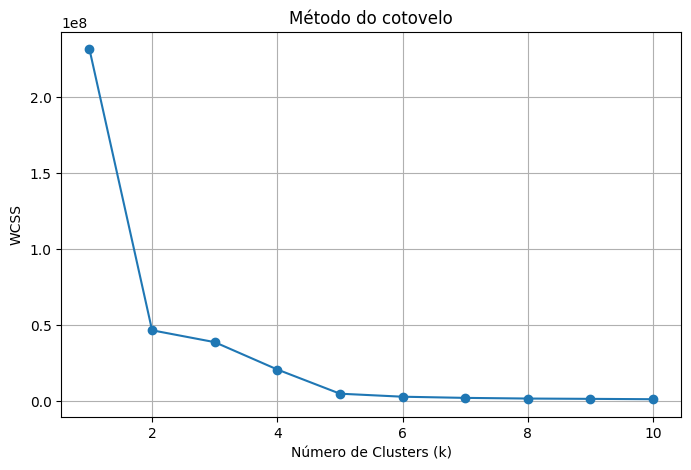

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

features = ['distance', 'diff_d1', 'dddt']
data = df[features]
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

print(wcss)
# Gráfico do Método do Cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Método do cotovelo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS")
plt.grid()
plt.show()


### Quais os valores dos centróides encontrados? Apresente graficamente.

Centróides encontrados:
[[ 5.31289352e+02  4.51388889e-01  1.50381983e-03]
 [ 1.83318750e+03 -1.04166667e-01  1.35005379e-03]
 [ 3.83575908e+02 -9.24092409e-02  7.41772826e-05]
 [ 4.60800000e+02 -1.34700000e+03 -2.27661892e+00]
 [ 1.80880000e+03  1.32460000e+03  3.91729154e+00]]


/home/git/APM20242-APRENDIZADO-DE-MAQUINA/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


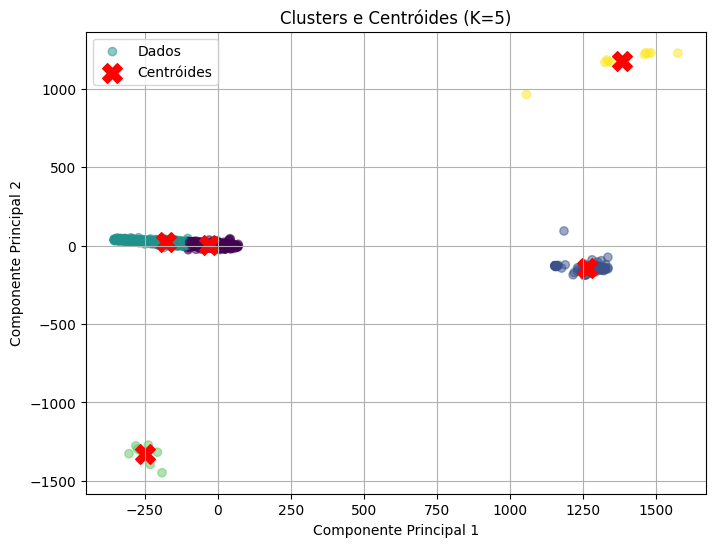

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicando o K-Means com o número ideal de clusters encontrado
k_otimo = 5
kmeans = KMeans(n_clusters=k_otimo, random_state=42)
clusters = kmeans.fit_predict(data)

# Criar um novo DataFrame com a coluna de cluster
df_clusters = df.copy()  # Cria uma cópia do DataFrame original
df_clusters["Cluster"] = clusters  # Adiciona a coluna de cluster

## DEBUG
debug = False
# Printar o número de amostras por cluster
if debug == True:
    print(df_clusters["Cluster"].value_counts())
    # Mostrar algumas amostras de cada cluster para analise de resultados
    for cluster_id in range(k_otimo):
        print(f"\nAmostras do Cluster {cluster_id}:")
        display(df_clusters[(df_clusters["Cluster"] == cluster_id) & (df_clusters["noise"] == True)])  # Exibir as primeiras amostras do cluster com noise True


# Obtendo os centróides
centroides = kmeans.cluster_centers_
print("Centróides encontrados:")
print(centroides)

# Reduzindo a dimensionalidade para visualização
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
centroides_pca = pca.transform(centroides)

# Plotando os clusters e os centróides
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5, label="Dados")
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], c='red', marker='X', s=200, label="Centróides")
plt.title(f"Clusters e Centróides (K={k_otimo})")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid()
plt.show()


### Obtenha o modelo de clusterização hierárquica que melhor se adequa aos dados. Qual o número de agrupamentos selecionados? Apresente o gráfico de clusterização obtido.

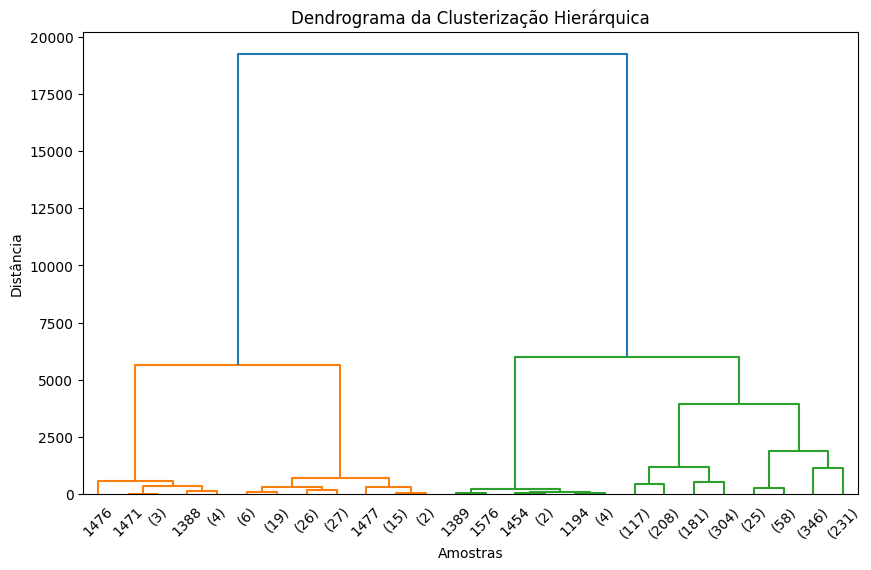

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Clusterização hierárquica
linked = linkage(data, method='ward')

# Plotando o dendrograma
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode="level", p=4)
plt.title("Dendrograma da Clusterização Hierárquica")
plt.xlabel("Amostras")
plt.ylabel("Distância")
plt.show()


### Comente os resultados com base na aplicação (dataset) utilizada

Nesta atividade, utilizamos o dataset device_833, no qual os modelos de classificação alcançaram 100% de acurácia em todas as métricas. No entanto, ao aplicar técnicas de clusterização, observamos que essa abordagem não se mostrou adequada para o problema, pelo menos com os dados disponíveis.

Tanto o K-Means quanto a Clusterização Hierárquica não conseguiram separar as amostras com ruído. Isso sugere que os padrões nos dados podem ser mais adequados para modelagem supervisionada, onde as classes já são conhecidas, do que para agrupamento não supervisionado.